# Hourly Energy Consumption.
![energy](energy.jpg)

# Giới thiệu project

Chủ đề: Hourly Energy Consumption.

Mục tiêu: 
- Phân tích xu hướng tiêu thụ điện theo thời gian và khu vực.
- Xây dựng mô hình dự báo tiêu thụ điện năng.
- Trình bày kết quả bằng đồ thị và báo cáo chi tiết.

---

## Import thư viện



- Xử lý và phân tích dữ liệu: `pandas`, `numpy`
- Vẽ biểu đồ: `matplotlib`, `seaborn`
- Dự báo và học máy: `xgboost`, `RandomForestRegressor`
- Đánh giá mô hình: `mean_absolute_error`, `mean_squared_error`, `r2_score`
- Phân tích chuỗi thời gian: `plot_acf`, `adfuller`
- Tiền xử lý và quy trình huấn luyện mô hình: `Pipeline`, `FunctionTransformer`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

---
# 1. Thu thập dữ liệu

Bài tập cung cấp nhiều tệp .csv tương ứng với dữ liệu tiêu thụ điện năng theo từng vùng (region) thuộc hệ thống lưới điện PJM. Mỗi file đại diện cho một khu vực như `AEP`, `COMED`, `DAYTON`,… và chứa thông tin tiêu thụ điện năng theo giờ. Trong đó, pjm_hourly_est.csv là file chứa các cột tương ứng với từng region, cùng một cột thời gian chung nên ta sẽ quan sát dữ liệu ở đây trước.

In [2]:
pjm_data = pd.read_csv('pjm_hourly_est.csv')
pjm_data['Datetime'] = pd.to_datetime(pjm_data['Datetime'])
pjm_data = pjm_data.set_index('Datetime')

In [3]:
pjm_data.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


Kiểm tra giá trị bị thiếu(NaN) trong từng cột thể hiện điện năng tiêu thụ của mỗi vùng

In [4]:
missing_values = pjm_data.isnull().sum()
print("Giá trị thiếu trong mỗi cột:\n", missing_values)
missing_percentage = (missing_values / len(pjm_data)) * 100
print("\nPhần trăm giá trị thiếu trong mỗi cột:")
for column, percentage in missing_percentage.items():
    print(f"{column}: {percentage:.2f}%")

Giá trị thiếu trong mỗi cột:
 AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

Phần trăm giá trị thiếu trong mỗi cột:
AEP: 31.97%
COMED: 62.70%
DAYTON: 31.97%
DEOK: 67.61%
DOM: 34.82%
DUQ: 33.21%
EKPC: 74.57%
FE: 64.73%
NI: 67.21%
PJME: 18.45%
PJMW: 19.67%
PJM_Load: 81.55%


Sau khi kiểm tra giá trị thiếu, tôi nhận thấy nhiều vùng có tỷ lệ thiếu >60%, gây khó khăn cho việc khai thác insight và xây dựng mô hình chính xác. Vì vậy, tôi quyết định phân tích từng vùng riêng biệt thay vì dùng dữ liệu tổng hợp. 
Tôi bắt đầu với vùng `PJME` vì vùng này có tỷ lệ thiếu thấp (~18%) và dữ liệu ổn định hơn.

In [5]:
PJME_df_origin = pd.read_csv('PJME_hourly.csv', encoding='utf-8-sig')

PJME_df = PJME_df_origin.copy()



---
# 2. Khám phá dữ liệu

In [6]:
PJME_df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [7]:
# In tên các cột để đảm bảo rằng cột 'Datetime' có mặt trong dữ liệu
print(PJME_df.columns.tolist())

['Datetime', 'PJME_MW']


### Kích thước và kiểu dữ liệu của các cột

In [8]:
# Các cột hiện có kiểu dữ liệu gì?
PJME_df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [9]:
PJME_df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Chuyển kiểu dữ liệu của cột `Datetime` từ dạng `object` (chuỗi) sang kiểu `datetime` để hỗ trợ xử lý dữ liệu thời gian như phân tích theo ngày, giờ, hoặc tạo chỉ mục thời gian.


In [10]:
PJME_df['Datetime'] = pd.to_datetime(PJME_df['Datetime'])


In [11]:
# Xử lý cột có thể bị lỗi tên
PJME_df.columns = PJME_df.columns.str.strip()  # Xóa khoảng trắng

# In thử tên cột để chắc chắn
print(PJME_df.columns.tolist())


['Datetime', 'PJME_MW']


### Kiểm tra dữ liệu bị trùng

In [12]:
print("Check of Duplicates:")
print(f"{PJME_df[PJME_df.duplicated()]}")

print("Check of Duplicates (Datetimes):")
print(f"{PJME_df[PJME_df['Datetime'].duplicated()]}")

Check of Duplicates:
Empty DataFrame
Columns: [Datetime, PJME_MW]
Index: []
Check of Duplicates (Datetimes):
                  Datetime  PJME_MW
106585 2014-11-02 02:00:00  23755.0
115369 2015-11-01 02:00:00  21171.0
124009 2016-11-06 02:00:00  21692.0
132817 2017-11-05 02:00:00  20666.0


### Kiểm tra dữ liệu bị thiếu

In [13]:
start = PJME_df['Datetime'].min()
end = PJME_df['Datetime'].max()

full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

missing_dates = full_range.difference(PJME_df['Datetime'])

print(f"Số lượng thời điểm bị thiếu: {len(missing_dates)}")
missing_dates

Số lượng thời điểm bị thiếu: 30


DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

##### Fact: Các thời điểm thiếu do sự thay đổi giữa giờ chuẩn và giờ mùa hè (DST)

Các thời điểm thiếu như `2002-04-07 03:00:00`, `2003-04-06 03:00:00`, v.v. đều rơi vào mùa xuân hoặc mùa thu, khi có sự thay đổi giữa giờ chuẩn và giờ mùa hè. 

- **Giờ mùa hè (DST)**: Trong một số quốc gia, vào mùa xuân và mùa thu, thời gian sẽ thay đổi — thường là giảm hoặc tăng một giờ. Ví dụ: 
  - Từ 3:00 AM có thể chuyển thành 2:00 AM (khi đổi từ giờ mùa hè về giờ chuẩn) hoặc 4:00 AM (khi đổi từ giờ chuẩn sang giờ mùa hè).
  
- **Nguyên nhân các thời điểm thiếu**: Các thời điểm này không xuất hiện trong dữ liệu vì khi đồng hồ được chỉnh lại vào mùa hè, một số thời điểm (như 3:00 AM) sẽ bị "bỏ qua" hoàn toàn trong chuỗi thời gian.


### Tạo thêm các đặc trưng thời gian

Tôi đã trích xuất thêm các đặc trưng từ cột `Datetime` như năm, quý, tháng, ngày, giờ, thứ trong tuần, ngày trong năm, cuối tuần và mùa trong năm. Những đặc trưng này có thể giúp mô hình học được các xu hướng theo thời gian và cải thiện hiệu suất dự đoán.


In [14]:
def create_features_Datetime(PJME_df):

  PJME_df['Year'] = PJME_df.index.year
  PJME_df['Quarter'] = PJME_df.index.quarter
  PJME_df['Month'] = PJME_df.index.month
  PJME_df['Day'] = PJME_df.index.day
  PJME_df['Hour'] = PJME_df.index.hour

  PJME_df['Day_of_Year'] = PJME_df.index.dayofyear

  PJME_df['Weekday'] = PJME_df.index.weekday
  PJME_df['Is_Weekend'] = PJME_df['Weekday'].isin([5, 6]).astype(int)

  PJME_df['Season'] = PJME_df['Month'].apply(lambda x: 
                                                         1 if (x >= 3 and x <= 5) else  # Xuân
                                                         2 if (x >= 6 and x <= 8) else  # Hạ
                                                         3 if (x >= 9 and x <= 11) else  # Thu
                                                         4) # Đông

  return PJME_df

In [15]:


PJME_df.set_index('Datetime', inplace=True)

PJME_df.pipe(create_features_Datetime).head()


,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,12,31,1,365,1,0,4
2002-12-31 02:00:00,25147.0,2002,4,12,31,2,365,1,0,4
2002-12-31 03:00:00,24574.0,2002,4,12,31,3,365,1,0,4
2002-12-31 04:00:00,24393.0,2002,4,12,31,4,365,1,0,4
2002-12-31 05:00:00,24860.0,2002,4,12,31,5,365,1,0,4


---
# 3. Tiền xử lí bước đầu

In [16]:
df_PJME_ts_raw = PJME_df_origin.copy()
df_PJME_ts_raw['Datetime'] = pd.to_datetime(df_PJME_ts_raw['Datetime'])

df_PJME_ts = df_PJME_ts_raw.copy()

df_PJME_ts = df_PJME_ts.set_index('Datetime').sort_index() # sắp xếp theo thời gian để chuẩn hóa dữ liệu
df_PJME_ts = df_PJME_ts.resample('h').mean() # ấy trung bình nếu có nhiều điểm trong cùng 1 giờ

df_PJME_ts['PJME_MW'] = df_PJME_ts['PJME_MW'].interpolate(method='time') # nội suy giá trị thiếu theo thời gian

df_PJME_ts.pipe(create_features_Datetime).head()

,PJME_MW,Year,Quarter,Month,Day,Hour,Day_of_Year,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,0,4
2002-01-01 02:00:00,29265.0,2002,1,1,1,2,1,1,0,4
2002-01-01 03:00:00,28357.0,2002,1,1,1,3,1,1,0,4
2002-01-01 04:00:00,27899.0,2002,1,1,1,4,1,1,0,4
2002-01-01 05:00:00,28057.0,2002,1,1,1,5,1,1,0,4


### Kiểm tra dữ liệu sau khi tiền xử lí
Có thể thấy, `4` cột bị trùng và `30` cột bị lặp đã được xử lí

In [17]:
df_PJME_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145392 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Freq: h
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PJME_MW      145392 non-null  float64
 1   Year         145392 non-null  int32  
 2   Quarter      145392 non-null  int32  
 3   Month        145392 non-null  int32  
 4   Day          145392 non-null  int32  
 5   Hour         145392 non-null  int32  
 6   Day_of_Year  145392 non-null  int32  
 7   Weekday      145392 non-null  int32  
 8   Is_Weekend   145392 non-null  int64  
 9   Season       145392 non-null  int64  
dtypes: float64(1), int32(7), int64(2)
memory usage: 8.3 MB


---
# 4. Phân tích khám phá dữ liệu (EDA) 

### Trực quan hóa tiêu thụ năng lượng trong suốt khoảng thời gian đã cho

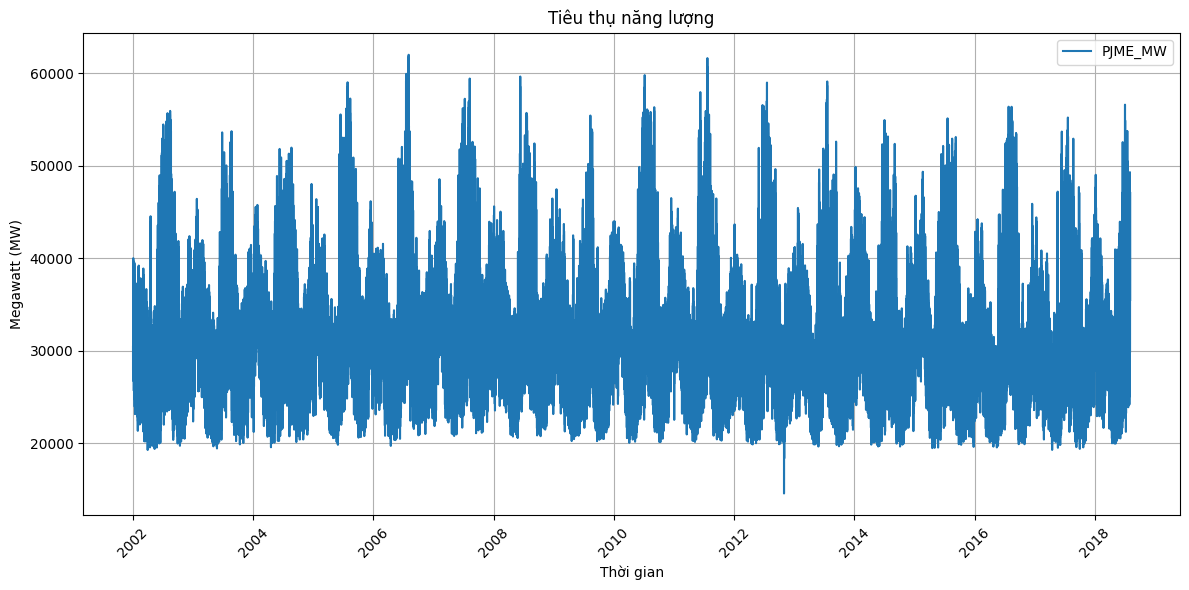

In [18]:
acf_color = '#1f77b4'   
zero_line_color = '#d62728'  
plt.figure(figsize=(12, 6))
plt.plot(df_PJME_ts.index, df_PJME_ts['PJME_MW'], label='PJME_MW', color=acf_color)
plt.title('Tiêu thụ năng lượng')
plt.xlabel('Thời gian')
plt.ylabel('Megawatt (MW)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Kiểm tra tính tự tương quan
Biểu đồ tương quan 7 ngày:
- Biểu đồ trên cho thấy mẫu lặp lại rõ ràng cứ mỗi 24 giờ, xác nhận dữ liệu tiêu thụ năng lượng có chu kỳ hàng ngày 
- Thể hiện tương quan mạnh giữa tiêu thụ năng lượng tại một giờ nhất định với cùng giờ đó vào ngày hôm sau

Biểu đồ tương quan 5 năm:
- Chu kỳ mùa vụ rõ ràng, với các đỉnh và đáy lặp lại theo thời gian
- Biên độ của các đỉnh giảm dần theo thời gian, cho thấy mối tương quan yếu dần khi khoảng cách thời gian tăng lên.

(-0.6, 1.2)

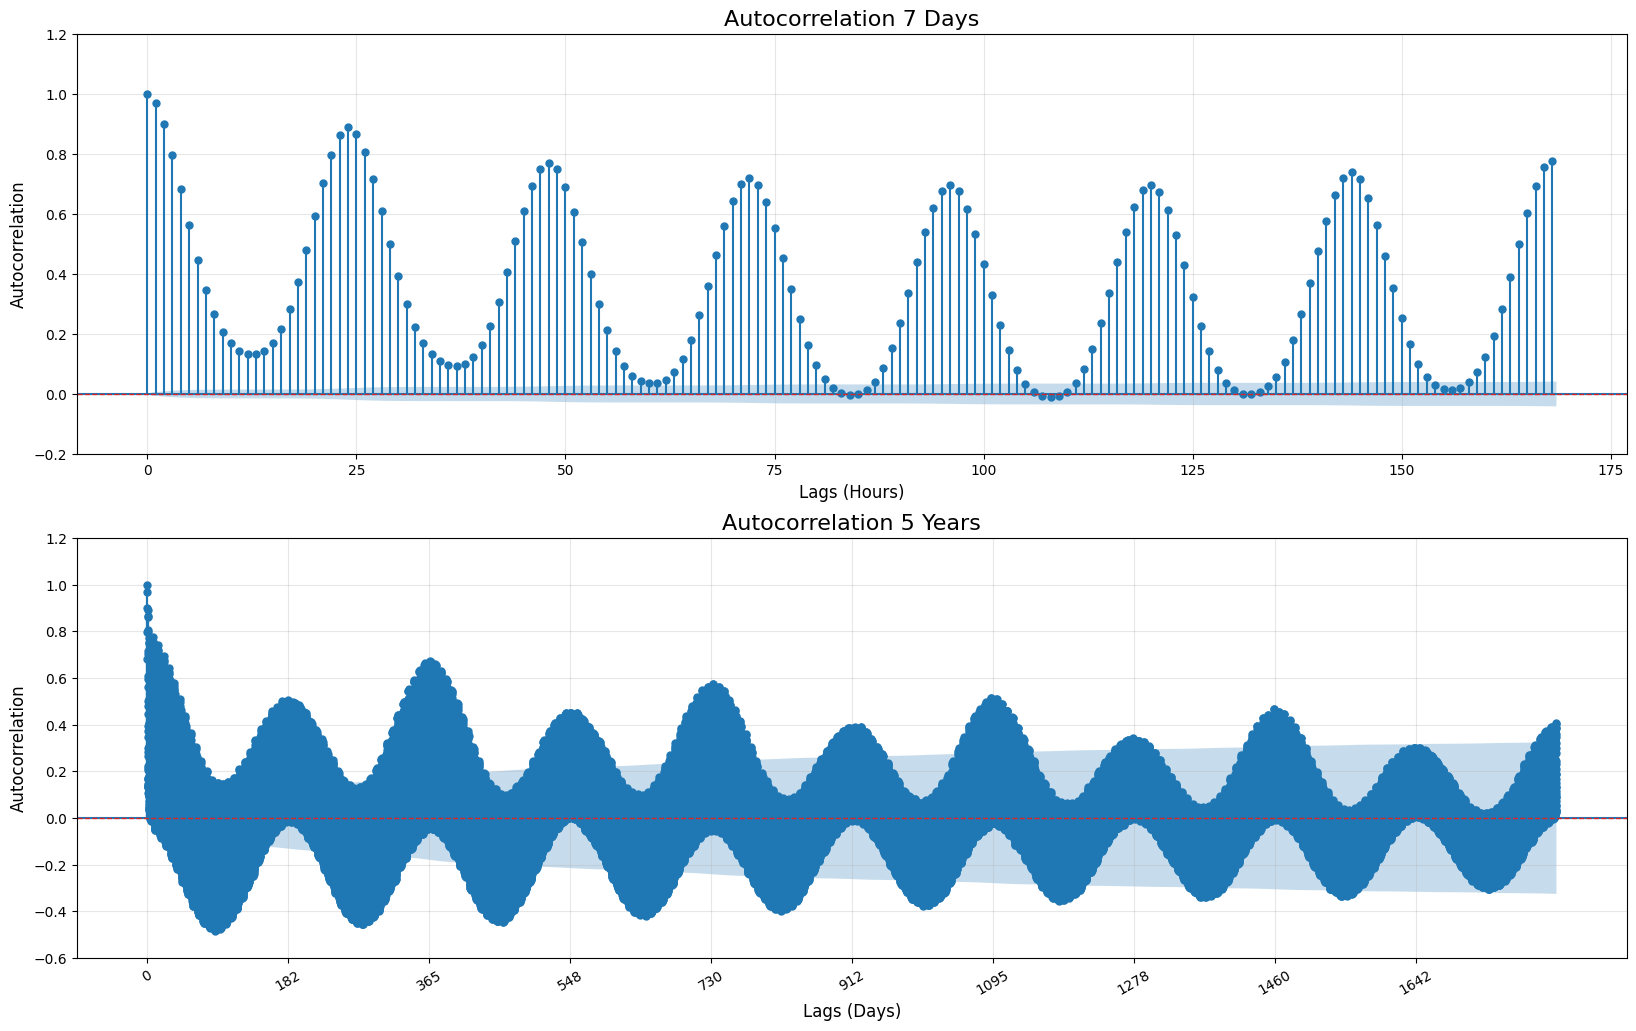

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))



plot_acf(PJME_df['PJME_MW'], lags=24*7, ax=ax[0], color=acf_color)
ax[0].set_title('Autocorrelation 7 Days', fontsize=16)
ax[0].set_xlabel('Lags (Hours)', fontsize=12)
ax[0].set_ylabel('Autocorrelation', fontsize=12)
ax[0].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)
ax[0].grid(alpha=0.3)

plot_acf(PJME_df['PJME_MW'], lags=24*365*5, ax=ax[1], color=acf_color)
ax[1].set_title('Autocorrelation 5 Years', fontsize=16)
ax[1].set_xlabel('Lags (Days)', fontsize=12)
ax[1].set_ylabel('Autocorrelation', fontsize=12)
ax[1].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)

hours_featured = [i for i in range(0, 5*365*24, 365*12)]
ax[1].set_xticks(hours_featured)
days_featured = [f"{hour / 24:.0f}" for hour in hours_featured]
ax[1].set_xticklabels(days_featured, rotation=30)

ax[1].grid(alpha=0.3)
ax[0].set_ylim(-0.2, 1.2)
ax[1].set_ylim(-0.6, 1.2)

### Kiểm tra tính dừng 

Chuỗi dừng là chuỗi thời gian có các đặc tính thống kê như kỳ vọng, phương sai và tự tương quan không thay đổi theo thời gian.

Khác với các mô hình thống kê truyền thống như ARIMA, XGBoost không yêu cầu chuỗi thời gian phải dừng. Tuy nhiên, việc hiểu và kiểm tra tính dừng của chuỗi vẫn rất quan trọng. Điều này giúp nhận diện các yếu tố như xu hướng (trend) và mùa vụ (seasonality) trong dữ liệu.

Dựa trên những hiểu biết này, ta có thể tạo ra các đặc trưng bổ sung như Year, Month, Day, Season, và Lag, từ đó giúp XGBoost học và hiểu cấu trúc thời gian của dữ liệu tốt hơn.

In [20]:
adf_result = adfuller(df_PJME_ts['PJME_MW'])
test_statistic, p_value, _, _, _, _ = adf_result

print(f'ADF Statistic: {test_statistic}')
print(f'P-value: {p_value}')

if p_value <= 0.05:
	print('Reject the null hypothesis: The time series is Stationary.')
else:
	print('Fail to reject the null hypothesis: The time series is Non-Stationary.')

ADF Statistic: -19.964593931840625
P-value: 0.0
Reject the null hypothesis: The time series is Stationary.


In [21]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### Tiêu thụ năng lượng trung bình theo giờ trong ngày
Xác định xu hướng tiêu thụ điện theo giờ
Tiêu thụ thấp nhất vào khoảng 3-5 giờ sáng, tăng dần trong ngày và đạt đỉnh vào buổi tối (18-19 giờ)

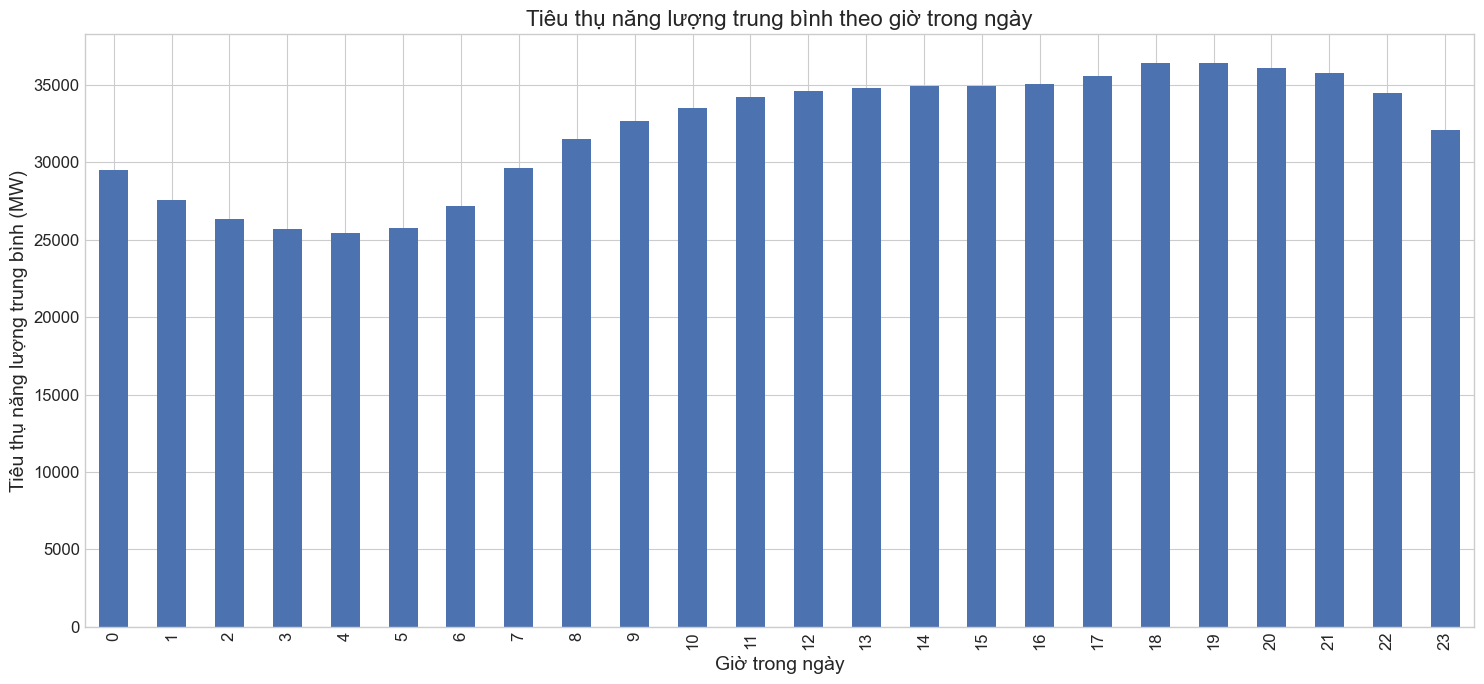

In [22]:
plt.figure(figsize=(15, 7))
hourly_avg = PJME_df.groupby('Hour')['PJME_MW'].mean()
hourly_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo giờ trong ngày', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Giờ trong ngày', fontsize=14)
plt.tight_layout()

### Năng lượng tiêu thụ trung bình của từng ngày trong tuần 

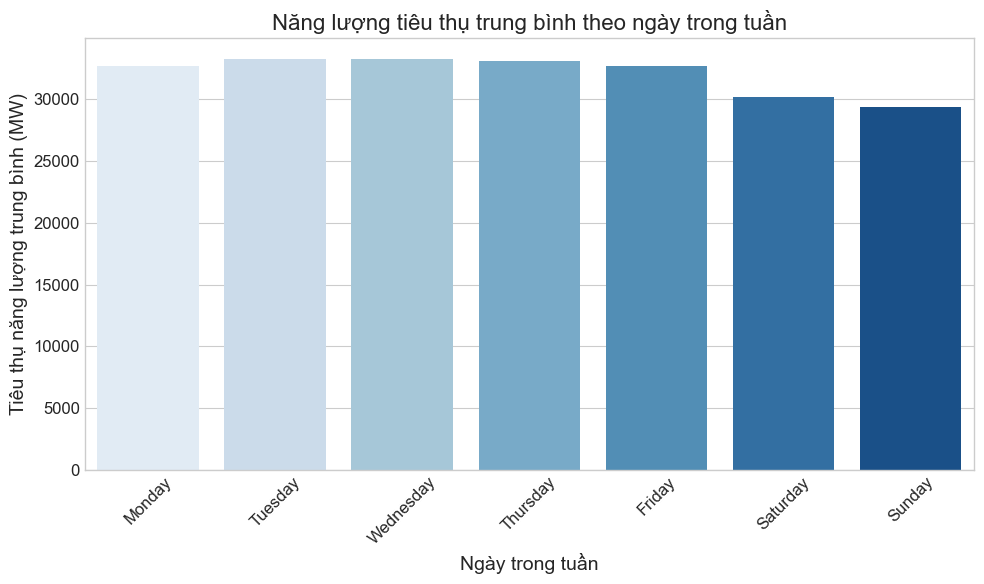

In [23]:
# Tạo cột 'dayofweek' để lấy ngày trong tuần (0 = Thứ Hai, 1 = Thứ Ba, ..., 6 = Chủ Nhật)
PJME_df['dayofweek'] = PJME_df.index.dayofweek

# Tạo ánh xạ tên ngày trong tuần cho dễ đọc
day_names = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

# Tính trung bình tiêu thụ năng lượng theo ngày trong tuần
daily_avg = PJME_df.groupby('dayofweek')['PJME_MW'].mean().reset_index()
daily_avg['day_name'] = daily_avg['dayofweek'].map(day_names)

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='PJME_MW', data=daily_avg, hue='day_name', palette='Blues', legend=False)
plt.title('Năng lượng tiêu thụ trung bình theo ngày trong tuần', fontsize=16)
plt.xlabel('Ngày trong tuần', fontsize=14)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Tiêu thụ năng lượng trung bình theo mùa
Mùa Hạ có tiêu thụ điện cao nhất, theo sau là mùa Đông

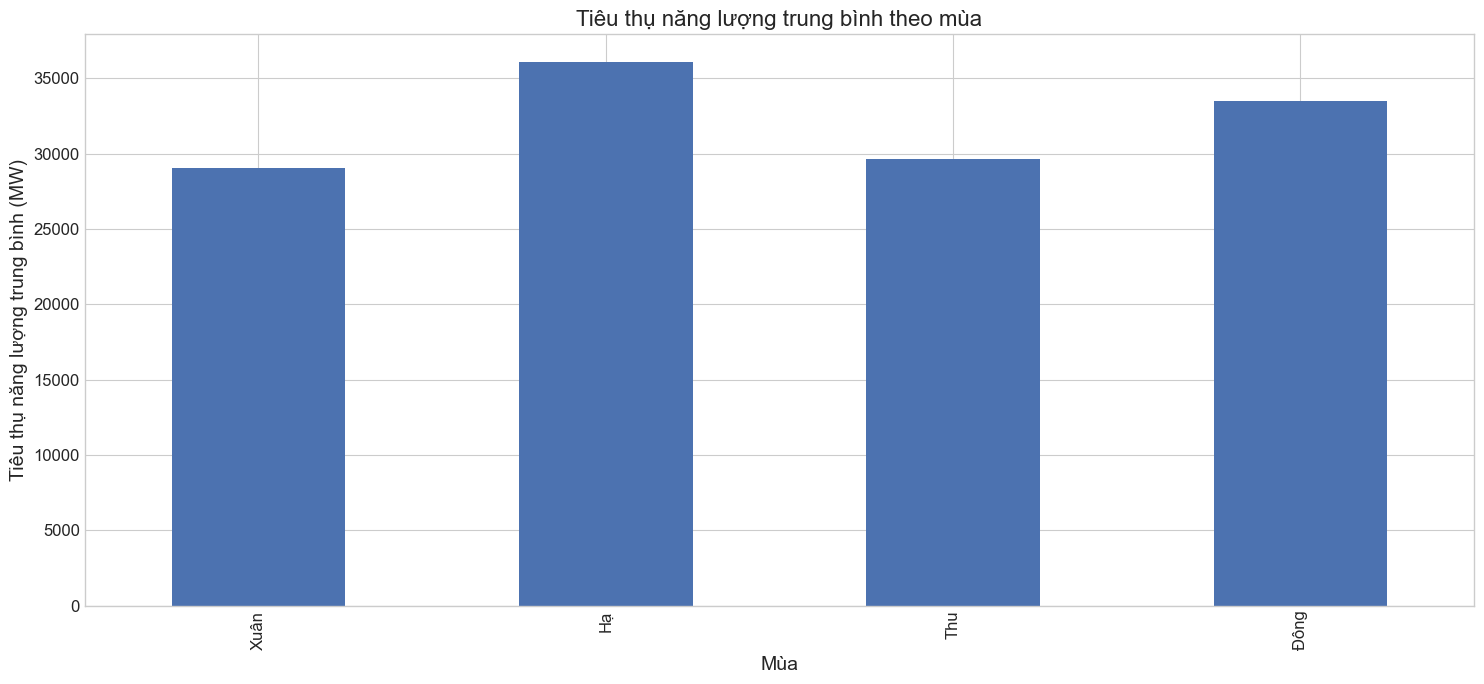

In [24]:
plt.figure(figsize=(15, 7))
season_names = ['Xuân', 'Hạ', 'Thu', 'Đông']
season_avg = PJME_df.groupby('Season')['PJME_MW'].mean()
season_avg.index = season_names
season_avg.plot(kind='bar')
plt.title('Tiêu thụ năng lượng trung bình theo mùa', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng trung bình (MW)', fontsize=14)
plt.xlabel('Mùa', fontsize=14)
plt.tight_layout()

### Biểu đố tương quan giữa các cột
Hour có tương quan dương mạnh nhất với `PJME_MW`. Có đa cộng tuyến cao giữa Month, Quarter và Day_of_Year

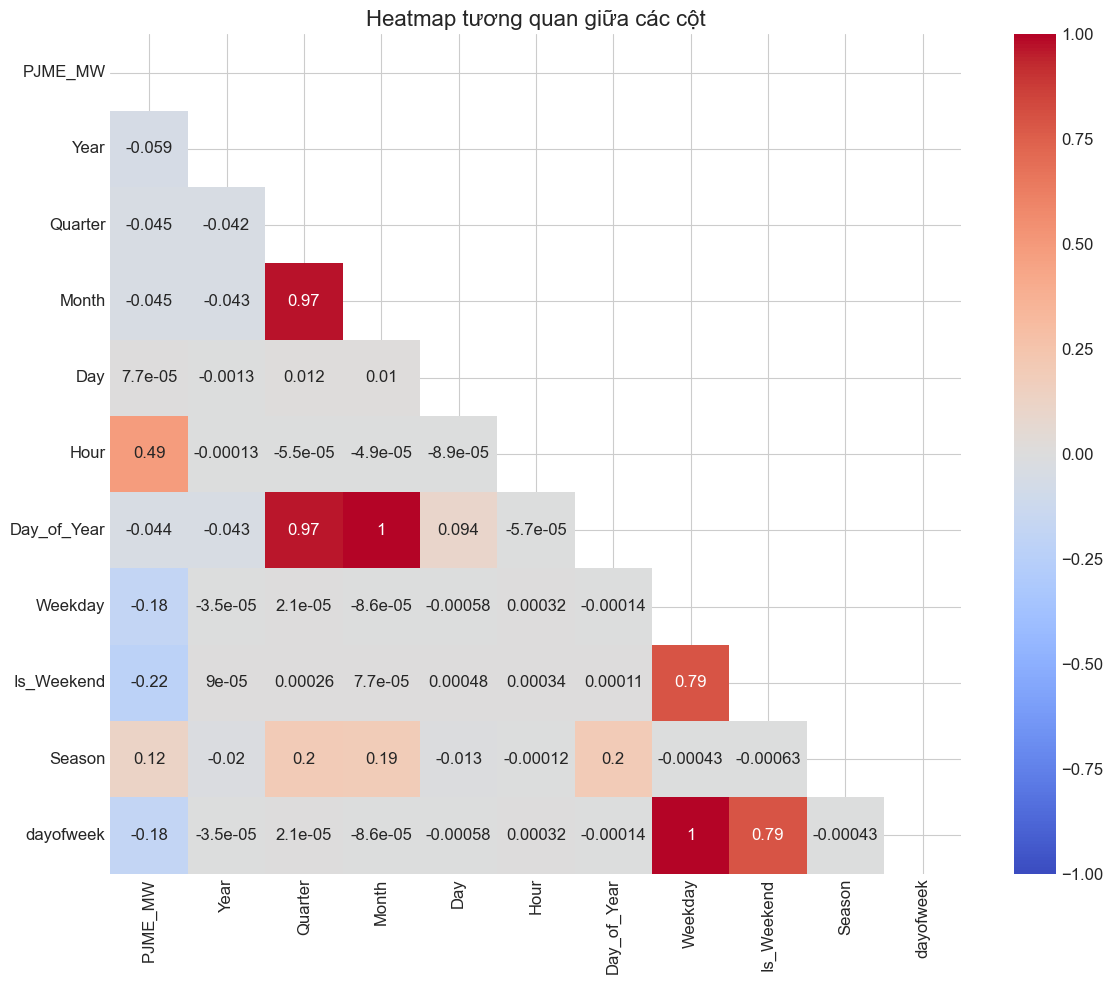

In [25]:
plt.figure(figsize=(12, 10))
correlation = PJME_df.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Heatmap tương quan giữa các cột', fontsize=16)
plt.tight_layout()

---
# 5. Tạo pipe tiền xử lí

### Feature engineering
Dựa trên biểu đồ tương quan theo độ trễ, tôi nhận thấy mẫu tiêu thụ năng lượng lặp lại rõ ràng theo chu kỳ 24 giờ – tức là có tính chu kỳ hàng ngày. Ngoài ra, giá trị tiêu thụ năng lượng tại một thời điểm cụ thể có tương quan mạnh với chính thời điểm đó vào ngày hôm sau.

In [26]:
def feature_engineering(df):
    df = df.copy()
    
    # Lag features
    for lag in [1, 24, 48, 72, 168]:
        df[f'lag_{lag}h'] = df['PJME_MW'].shift(lag)

    # Rolling statistics (shift before rolling to avoid leakage)
    for window in [24, 168]:
        df[f'rolling_mean_{window}h'] = df['PJME_MW'].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}h']  = df['PJME_MW'].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}h']  = df['PJME_MW'].shift(1).rolling(window=window).min()
        df[f'rolling_max_{window}h']  = df['PJME_MW'].shift(1).rolling(window=window).max()

    # Differencing (change over time)
    df['diff_1h'] = df['PJME_MW'].diff(1)
    df['diff_24h'] = df['PJME_MW'].diff(24)

    # Drop rows with any NaN values from above
    df.dropna(inplace=True)

    return df


Xử lí missing value sau khi tạo các cột đặc trưng

In [27]:
def fillna(df):
    # Tạo bản sao của dataframe để tránh thay đổi dữ liệu gốc
    df = df.copy()

    # Điền giá trị thiếu (NaN) trong các cột độ trễ (lag features)
    for col in df.columns:
        if col.startswith('lag_'):
            # Nhóm dữ liệu theo giờ trong ngày và điền giá trị thiếu (NaN) bằng giá trị trung bình của từng nhóm
            df[col] = df.groupby(df.index.hour)[col].transform(lambda x: x.fillna(x.mean()))

    # Điền giá trị thiếu cho các cột thống kê trượt (rolling statistics)
    for window in [24, 168]:
        # Xác định các giá trị NaN trong cột 'rolling_mean_{window}h'
        mask = df[f'rolling_mean_{window}h'].isna()
        
        # Điền giá trị NaN trong 'rolling_mean_{window}h' bằng giá trị từ cột 'PJME_MW' (dữ liệu gốc)
        df.loc[mask, f'rolling_mean_{window}h'] = df.loc[mask, 'PJME_MW']
        
        # Điền giá trị thiếu trong các cột độ lệch chuẩn (rolling_std) bằng 0
        df[f'rolling_std_{window}h'] = df[f'rolling_std_{window}h'].fillna(0)
        
        # Điền giá trị NaN trong các cột 'rolling_min_{window}h' và 'rolling_max_{window}h' bằng giá trị từ cột 'PJME_MW'
        df.loc[mask, f'rolling_min_{window}h'] = df.loc[mask, 'PJME_MW']
        df.loc[mask, f'rolling_max_{window}h'] = df.loc[mask, 'PJME_MW']

    # Điền giá trị thiếu trong các cột 'diff_1h' và 'diff_24h' bằng 0
    df['diff_1h'] = df['diff_1h'].fillna(0)
    df['diff_24h'] = df['diff_24h'].fillna(0)

    # Trả về dataframe đã được điền giá trị thiếu
    return df


In [28]:
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(feature_engineering)),
    ('fillna_handling', FunctionTransformer(fillna))
])

Sau khi xây dựng pipeline tiền xử lý gồm các bước tạo đặc trưng và xử lý giá trị khuyết (NaN), tôi áp dụng pipeline này cho toàn bộ dữ liệu gốc:

In [29]:
processed_df = preprocessing_pipeline.fit_transform(df_PJME_ts.copy())
print(processed_df)

                     PJME_MW  Year  Quarter  Month  Day  Hour  Day_of_Year  \
Datetime                                                                     
2002-01-08 01:00:00  29445.0  2002        1      1    8     1            8   
2002-01-08 02:00:00  28670.0  2002        1      1    8     2            8   
2002-01-08 03:00:00  28375.0  2002        1      1    8     3            8   
2002-01-08 04:00:00  28542.0  2002        1      1    8     4            8   
2002-01-08 05:00:00  29261.0  2002        1      1    8     5            8   
...                      ...   ...      ...    ...  ...   ...          ...   
2018-08-02 20:00:00  44057.0  2018        3      8    2    20          214   
2018-08-02 21:00:00  43256.0  2018        3      8    2    21          214   
2018-08-02 22:00:00  41552.0  2018        3      8    2    22          214   
2018-08-02 23:00:00  38500.0  2018        3      8    2    23          214   
2018-08-03 00:00:00  35486.0  2018        3      8    3     0   

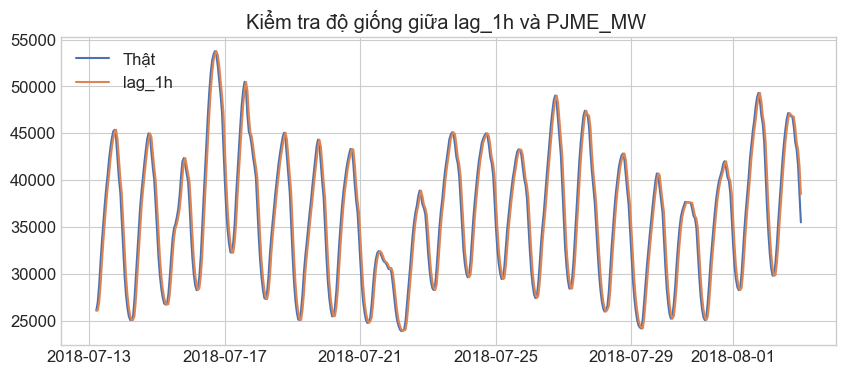

In [30]:


plt.figure(figsize=(10,4))
plt.plot(processed_df['PJME_MW'].iloc[-500:], label='Thật')
plt.plot(processed_df['lag_1h'].iloc[-500:], label='lag_1h')
plt.legend()
plt.title('Kiểm tra độ giống giữa lag_1h và PJME_MW ')
plt.show()


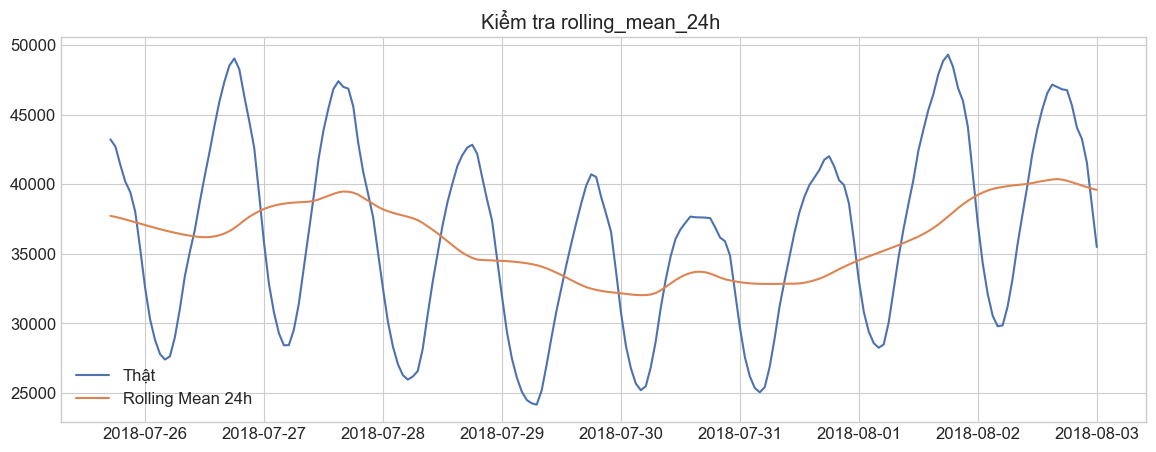

In [31]:
plt.figure(figsize=(14,5))
plt.plot(processed_df['PJME_MW'].iloc[-200:], label='Thật')
plt.plot(processed_df['rolling_mean_24h'].iloc[-200:], label='Rolling Mean 24h')
plt.legend()
plt.title("Kiểm tra rolling_mean_24h ")
plt.show()


In [32]:
feature_columns = ['Hour', 'Weekday', 'Month',
                   'lag_1h', 'lag_24h',
                   'rolling_mean_24h', 'diff_1h', 'diff_24h']

### Chia tập dữ liệu train/ test
80% train, 20% test

In [33]:
train_size = int(0.8 * len(processed_df))
train_data = processed_df.iloc[:train_size]
test_data = processed_df.iloc[train_size:]

X_train = train_data[feature_columns]
y_train = train_data['PJME_MW']

X_test = test_data[feature_columns]
y_test = test_data['PJME_MW']

---
# 6. Xây dựng mô hình

In [238]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các tham số cần thử
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500]
}

# Khởi tạo mô hình XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=2)

# Tiến hành tìm kiếm GridSearchCV
grid_search.fit(X_train, y_train)

# Hiển thị các tham số tốt nhất
print("Best parameters found: ", grid_search.best_params_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.9; tot

In [35]:
# Khởi tạo mô hình với các siêu tham số đã tìm được
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
xgb_predictions = xgb_model.predict(X_test)

### Đánh giá

In [36]:
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
xgb_r2 = r2_score(y_test, xgb_predictions)

print(f"XGBoost - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.4f}")

XGBoost - MAE: 43.24, RMSE: 71.63, R²: 0.9999


In [37]:
mask = y_test != 0
mape = np.mean(np.abs((y_test[mask] - xgb_predictions[mask]) / y_test[mask])) * 100

# Accuracy (dạng phần trăm)
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 0.14%
Accuracy: 99.86%


In [38]:
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R²: {np.mean(scores):.4f}")

Cross-validated R² scores: [0.9998448  0.99939323 0.99976656 0.99961654 0.99959411]
Mean R²: 0.9996


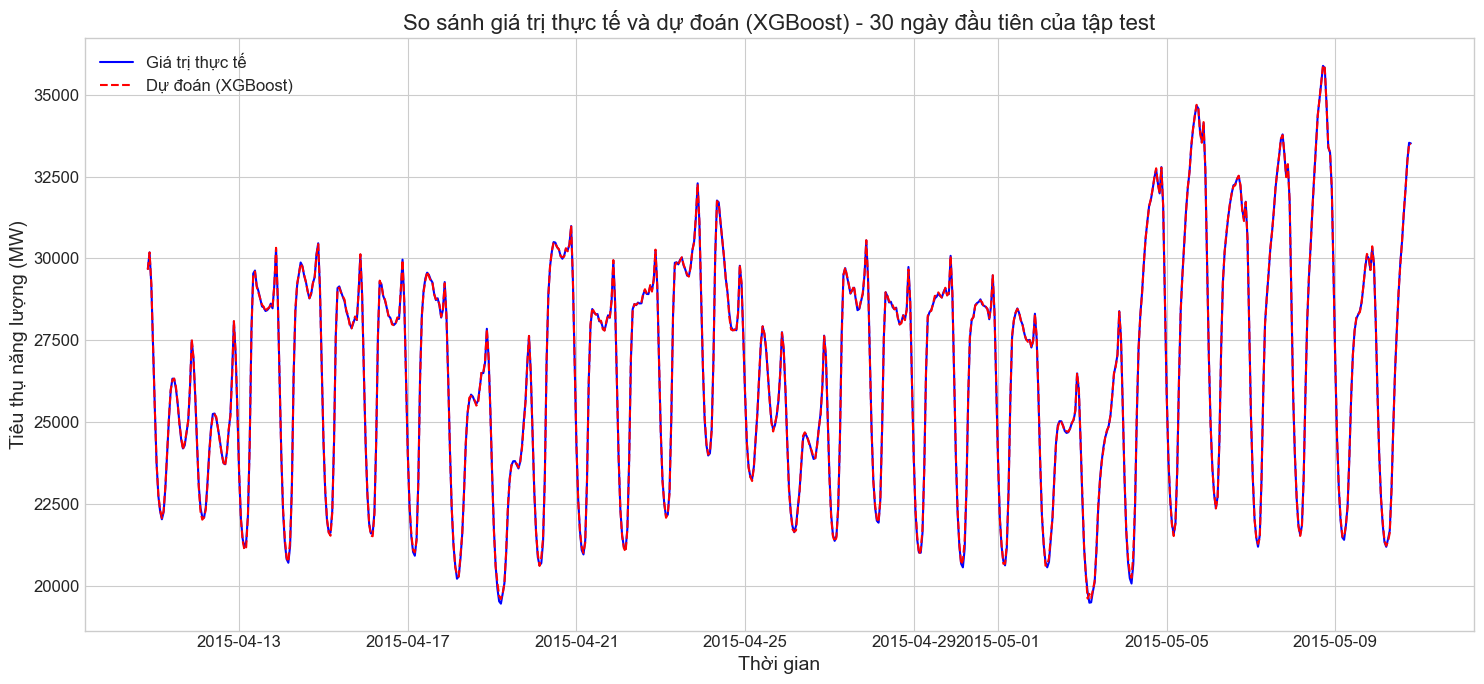

In [39]:
plt.figure(figsize=(15, 7))
test_sample = test_data.iloc[:30*24]
test_sample_predictions = xgb_predictions[:30*24]
model_name = "XGBoost"

plt.plot(test_sample.index, test_sample['PJME_MW'], label='Giá trị thực tế', color='blue')
plt.plot(test_sample.index, test_sample_predictions, label=f'Dự đoán ({model_name})', color='red', linestyle='--')
plt.title(f'So sánh giá trị thực tế và dự đoán ({model_name}) - 30 ngày đầu tiên của tập test', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng (MW)', fontsize=14)
plt.xlabel('Thời gian', fontsize=14)
plt.legend()
plt.tight_layout()

### Lưu model

In [40]:
# xgb_model.save_model("xgb_model.json") 

---
# 7. Thử nghiệm mô hình trên toàn dữ liệu


In [41]:
processed_df_v2 = preprocessing_pipeline.fit_transform(df_PJME_ts.copy())
X_full = processed_df_v2[feature_columns]

In [42]:
y_full_pred = xgb_model.predict(X_full)

C:\Users\LAPTOP\AppData\Local\Temp\ipykernel_6712\4106924621.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data = resampled_data.resample('24H').mean()


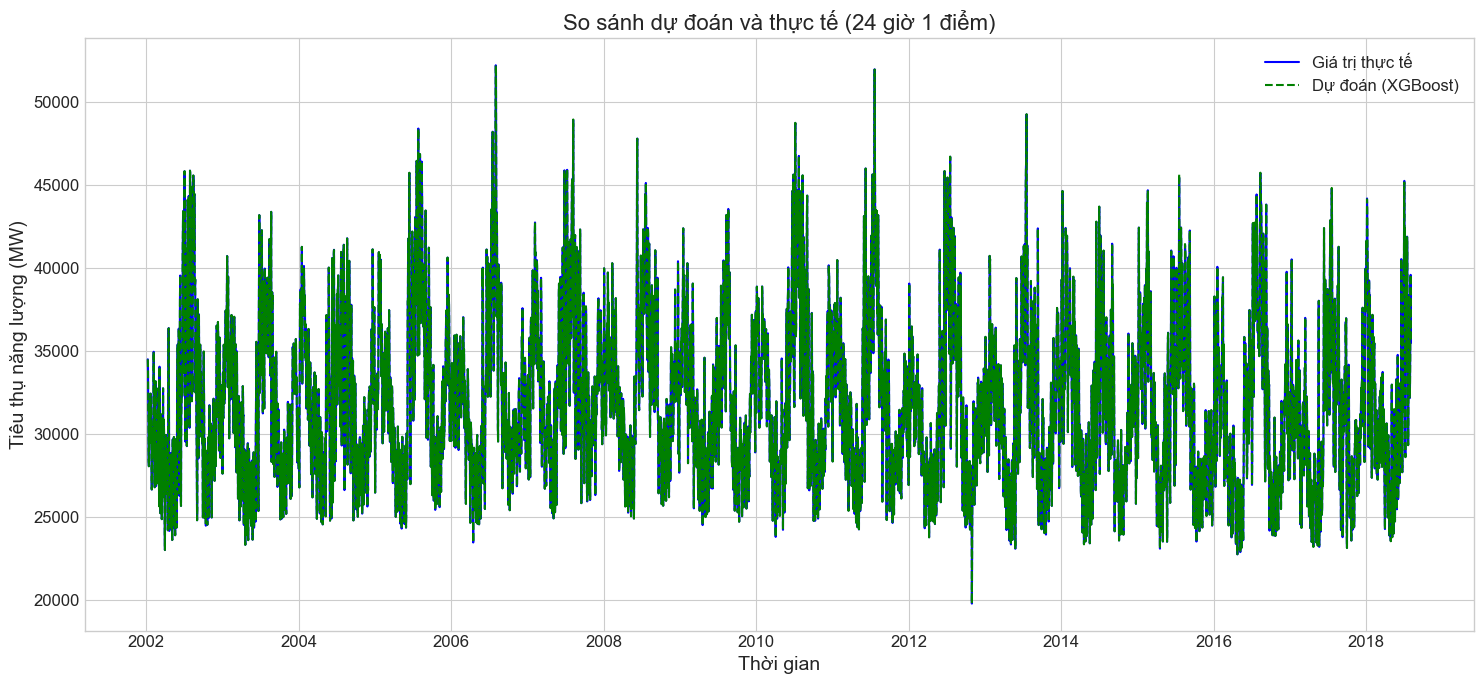

In [43]:
resampled_data = processed_df_v2.copy()
resampled_data['Prediction'] = y_full_pred
resampled_data = resampled_data.resample('24H').mean()

plt.figure(figsize=(15, 7))
plt.plot(resampled_data.index, resampled_data['PJME_MW'], label='Giá trị thực tế', color='blue')
plt.plot(resampled_data.index, resampled_data['Prediction'], label='Dự đoán (XGBoost)', color='green', linestyle='--')
plt.title('So sánh dự đoán và thực tế (24 giờ 1 điểm)', fontsize=16)
plt.ylabel('Tiêu thụ năng lượng (MW)', fontsize=14)
plt.xlabel('Thời gian', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Dự đoán trên tập huấn luyện
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Tính lỗi
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train MAE: {mae_train:.2f}, Test MAE: {mae_test:.2f}")
print(f"Train RMSE: {rmse_train:.2f}, Test RMSE: {rmse_test:.2f}")

Train MAE: 30.66, Test MAE: 43.24
Train RMSE: 39.44, Test RMSE: 71.63
